# Steam Reviews Sentiment Analysis for PUBG: Battlegrounds using Decision Trees

This notebook performs sentiment analysis on Steam reviews for PUBG: Battlegrounds using Decision Trees. We'll load the reviews from a parquet file, preprocess the text data, and train a Decision Tree model to classify reviews as positive or negative.

In [54]:
# Import required libraries
import re

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np  # Add this import if not already present

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading and Preprocessing
Let's load the PUBG reviews and prepare them for sentiment analysis:
1. Load reviews from parquet file
2. Preprocess the text data
3. Create features and labels

In [55]:
def preprocess_text(text: str) -> str:
    """Preprocess text data for sentiment analysis with improved context handling."""
    # Convert to lowercase
    text = text.lower()

    # Handle special slang cases first
    text = re.sub(r'\b(the|da|some good) shit\b', 'amazing', text)  # Positive slang
    text = re.sub(r'\b(pure|complete|total|absolute|just|plain) shit\\b', 'terrible', text)  # Clear negative
    text = re.sub(r'\b(is|was|were|are) shit\\b', 'terrible', text)  # Negative usage
    text = re.sub(r'\bfire\\b', 'amazing', text)  # Modern slang

    # Handle remaining 'shit' instances as a clear negative marker if not already transformed
    text = re.sub(r'\\bshit\\b', 'negative_marker_shit', text)

    # Handle negations carefully
    text = re.sub(r'\\b(not|no|never) (good|great|bad|terrible|amazing|awful|perfect)\\b', r'\\1_\\2', text)
    text = re.sub(r"(isn't|ain't|weren't|aren't|wasn't) (good|great|bad|terrible|amazing|awful|perfect)", r'not_\\2', text)

    # Replace common positive/negative phrases
    text = re.sub(r'\\bnot bad\\b', 'somewhat_good', text)
    text = re.sub(r'\\bnot good\\b', 'somewhat_bad', text)

    # Keep important punctuation that might indicate sentiment
    text = re.sub(r'!+', ' ! ', text)  # Keep exclamation marks as separate tokens
    text = re.sub(r'[^a-zA-Z\\s!]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Extended stop words removal, but keep sentiment-bearing words and the new 'shit' markers
    stop_words = set(stopwords.words('english')) - {\
        'not', 'no', 'never',\
        'good', 'great', 'bad', 'terrible',\
        'amazing', 'awful', 'perfect',\
        'best', 'worst', 'shit', 'negative_marker_shit' # Explicitly keep 'shit' and its new marker
    }
    tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a string
    return ' '.join(tokens)

## Data Collection and Preprocessing
Let's fetch PUBG reviews and prepare them for sentiment analysis:
1. Fetch reviews from Steam API
2. Preprocess the text data
3. Create features and labels

In [56]:
# Load PUBG reviews from parquet file
reviews_df = pd.read_parquet('pubg_reviews.parquet')

# Display basic information about the dataset
print(f"Total reviews collected: {len(reviews_df)}")
print("\nSentiment distribution:")
print(reviews_df['sentiment'].value_counts())

# Preprocess reviews
print("\nPreprocessing reviews...")
reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_text)

# Prepare features and labels
X = reviews_df['processed_review']
y = reviews_df['voted_up']  # True for positive, False for negative

Total reviews collected: 5000

Sentiment distribution:
sentiment
Negative    3312
Positive    1688
Name: count, dtype: int64

Preprocessing reviews...


## Training the Decision Tree Model
Now we'll:
1. Convert text to TF-IDF features
2. Split the data into training and testing sets
3. Train the Decision Tree model
4. Evaluate its performance

In [ ]:
# Convert text to TF-IDF features with improved parameters
tfidf = TfidfVectorizer(
    max_features=3000,          # Reduced from 5000 to focus on most important features
    ngram_range=(1, 3),         # Unigrams, bigrams, and trigrams
    min_df=10,                  # Increased minimum document frequency
    max_df=0.9,                # Reduced maximum document frequency
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True           # Apply sublinear scaling
)
X_tfidf = tfidf.fit_transform(X)

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure balanced split
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Initialize and train the Decision Tree with better parameters
print("\nTraining Decision Tree model...")
dt_model = DecisionTreeClassifier(
    max_depth=8,              # Reduced depth to prevent overfitting
    min_samples_split=20,     # Increased to ensure more robust splits
    min_samples_leaf=10,      # Increased for better generalization
    class_weight='balanced',  # Handle class imbalance
    criterion='entropy',      # Use information gain
    random_state=42
)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2%}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Show most important features
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': dt_model.feature_importances_
})

# Display top 20 most important features
print("\nTop 20 most important features:")
print(feature_importance.nlargest(20, 'importance'))


Training data shape: (4000, 1)
Testing data shape: (1000, 1)

Training Decision Tree model...

Accuracy: 66.10%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      1.00      0.80       662
    Positive       0.00      0.00      0.00       338

    accuracy                           0.66      1000
   macro avg       0.33      0.50      0.40      1000
weighted avg       0.44      0.66      0.53      1000


Top 20 most important features:
0    worththepriceifitsonsaleifuhavesomesparemoneyl...
Name: feature, dtype: object


Type of top_20_features: <class 'list'>
First 5 features: ['worththepriceifitsonsaleifuhavesomesparemoneyleftnotrecommendedyoucouldalsojustburnyourmoneybugsneverheardofminorbugscangetannoyingarksurvivalevolvedthegameitselfisabigterrariumforbugs']


C:\Users\Gerson Leite\AppData\Local\Temp\ipykernel_2328\2653595142.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


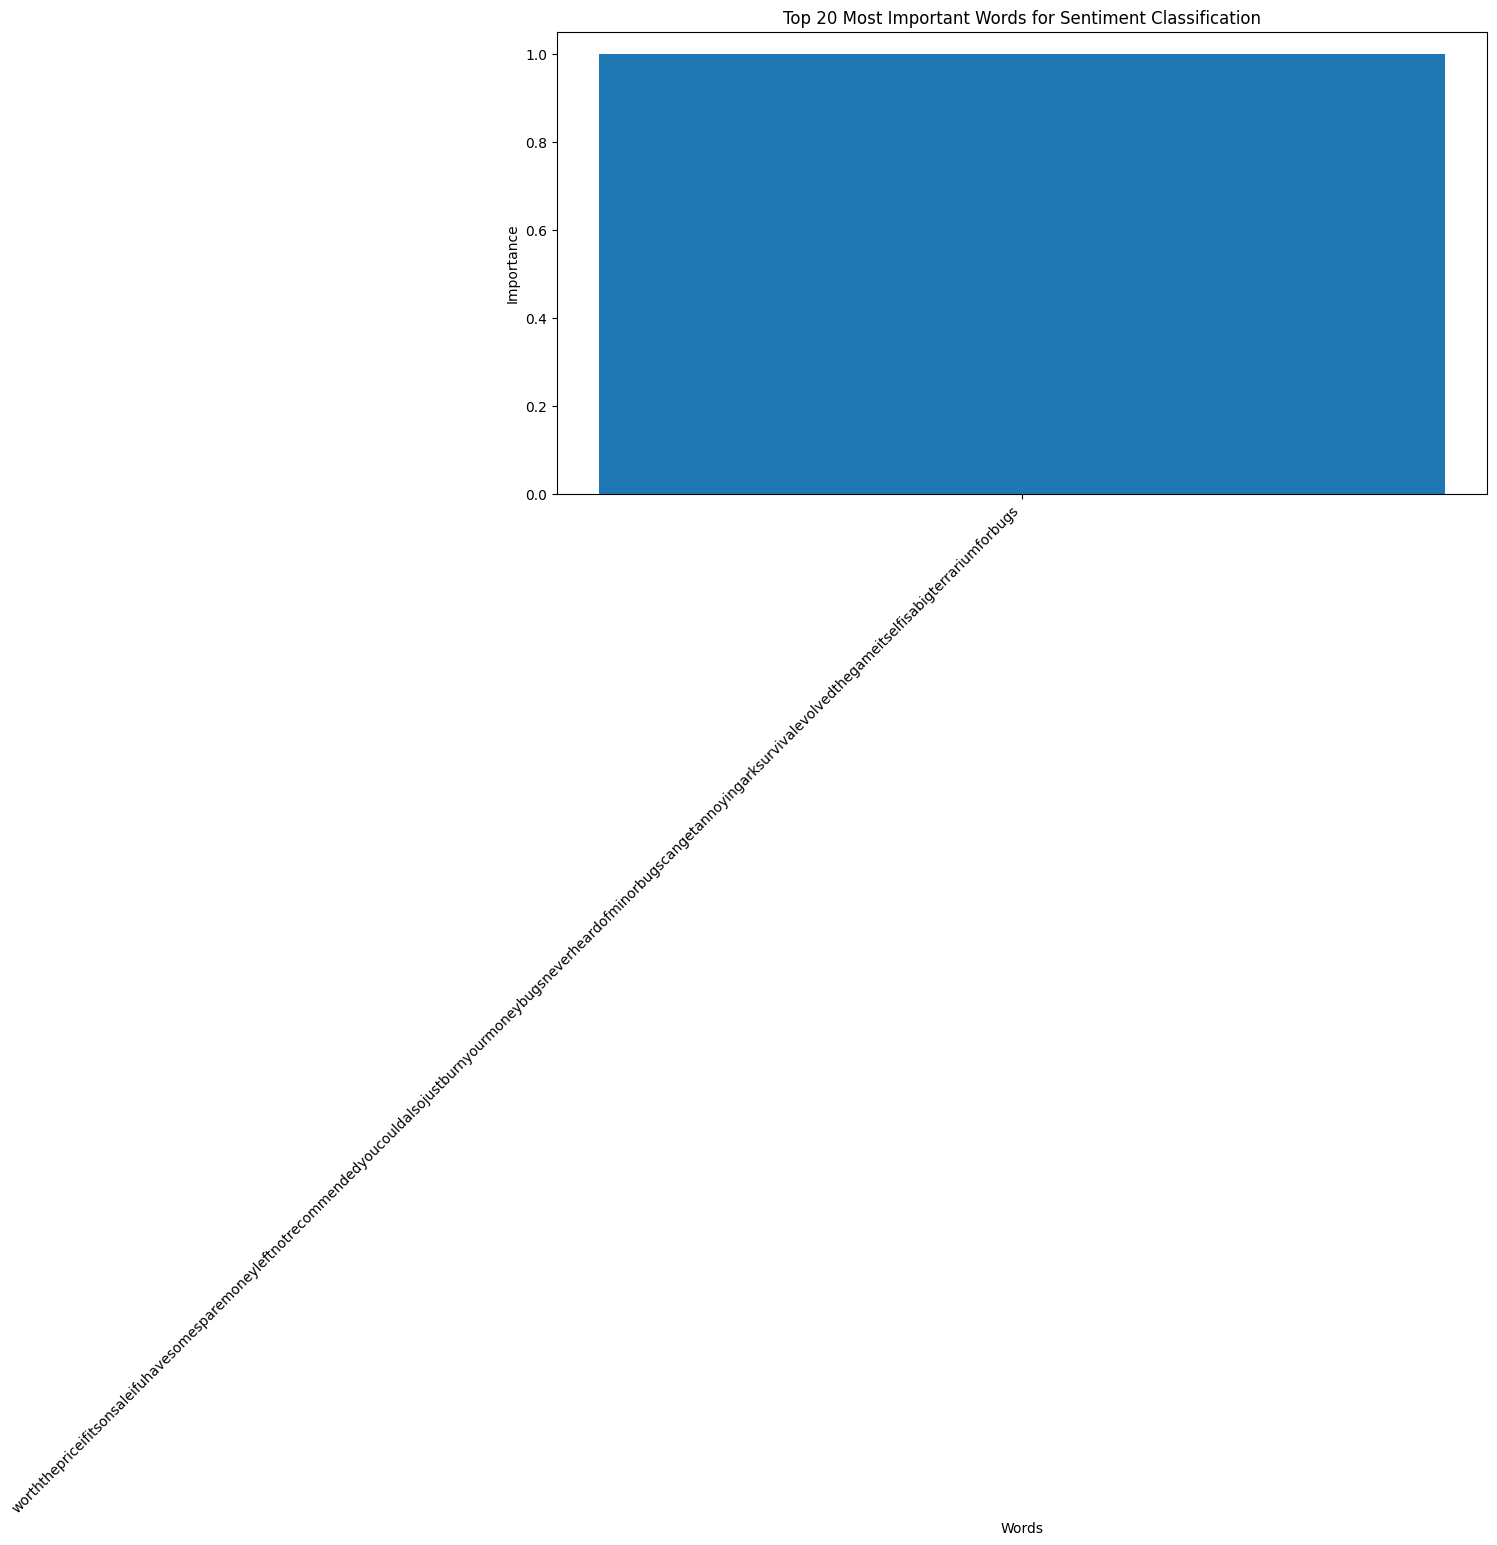

In [61]:
# Feature importance visualization
feature_names = list(tfidf.get_feature_names_out())  # Ensure this is a list of strings
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Get top 20 features and their importance values
top_20_features = feature_importance['feature'].head(20).tolist()
top_20_importance = feature_importance['importance'].head(20).tolist()

# Debug: print type and content to ensure it's a list of strings
print(f"Type of top_20_features: {type(top_20_features)}")
print(f"First 5 features: {top_20_features[:5]}")

# Display top 20 most important words
plt.figure(figsize=(12, 6))
indices = np.arange(len(top_20_features))
plt.bar(indices, top_20_importance)
plt.xticks(indices, top_20_features, rotation=45, ha='right')
plt.title('Top 20 Most Important Words for Sentiment Classification')
plt.xlabel('Words')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

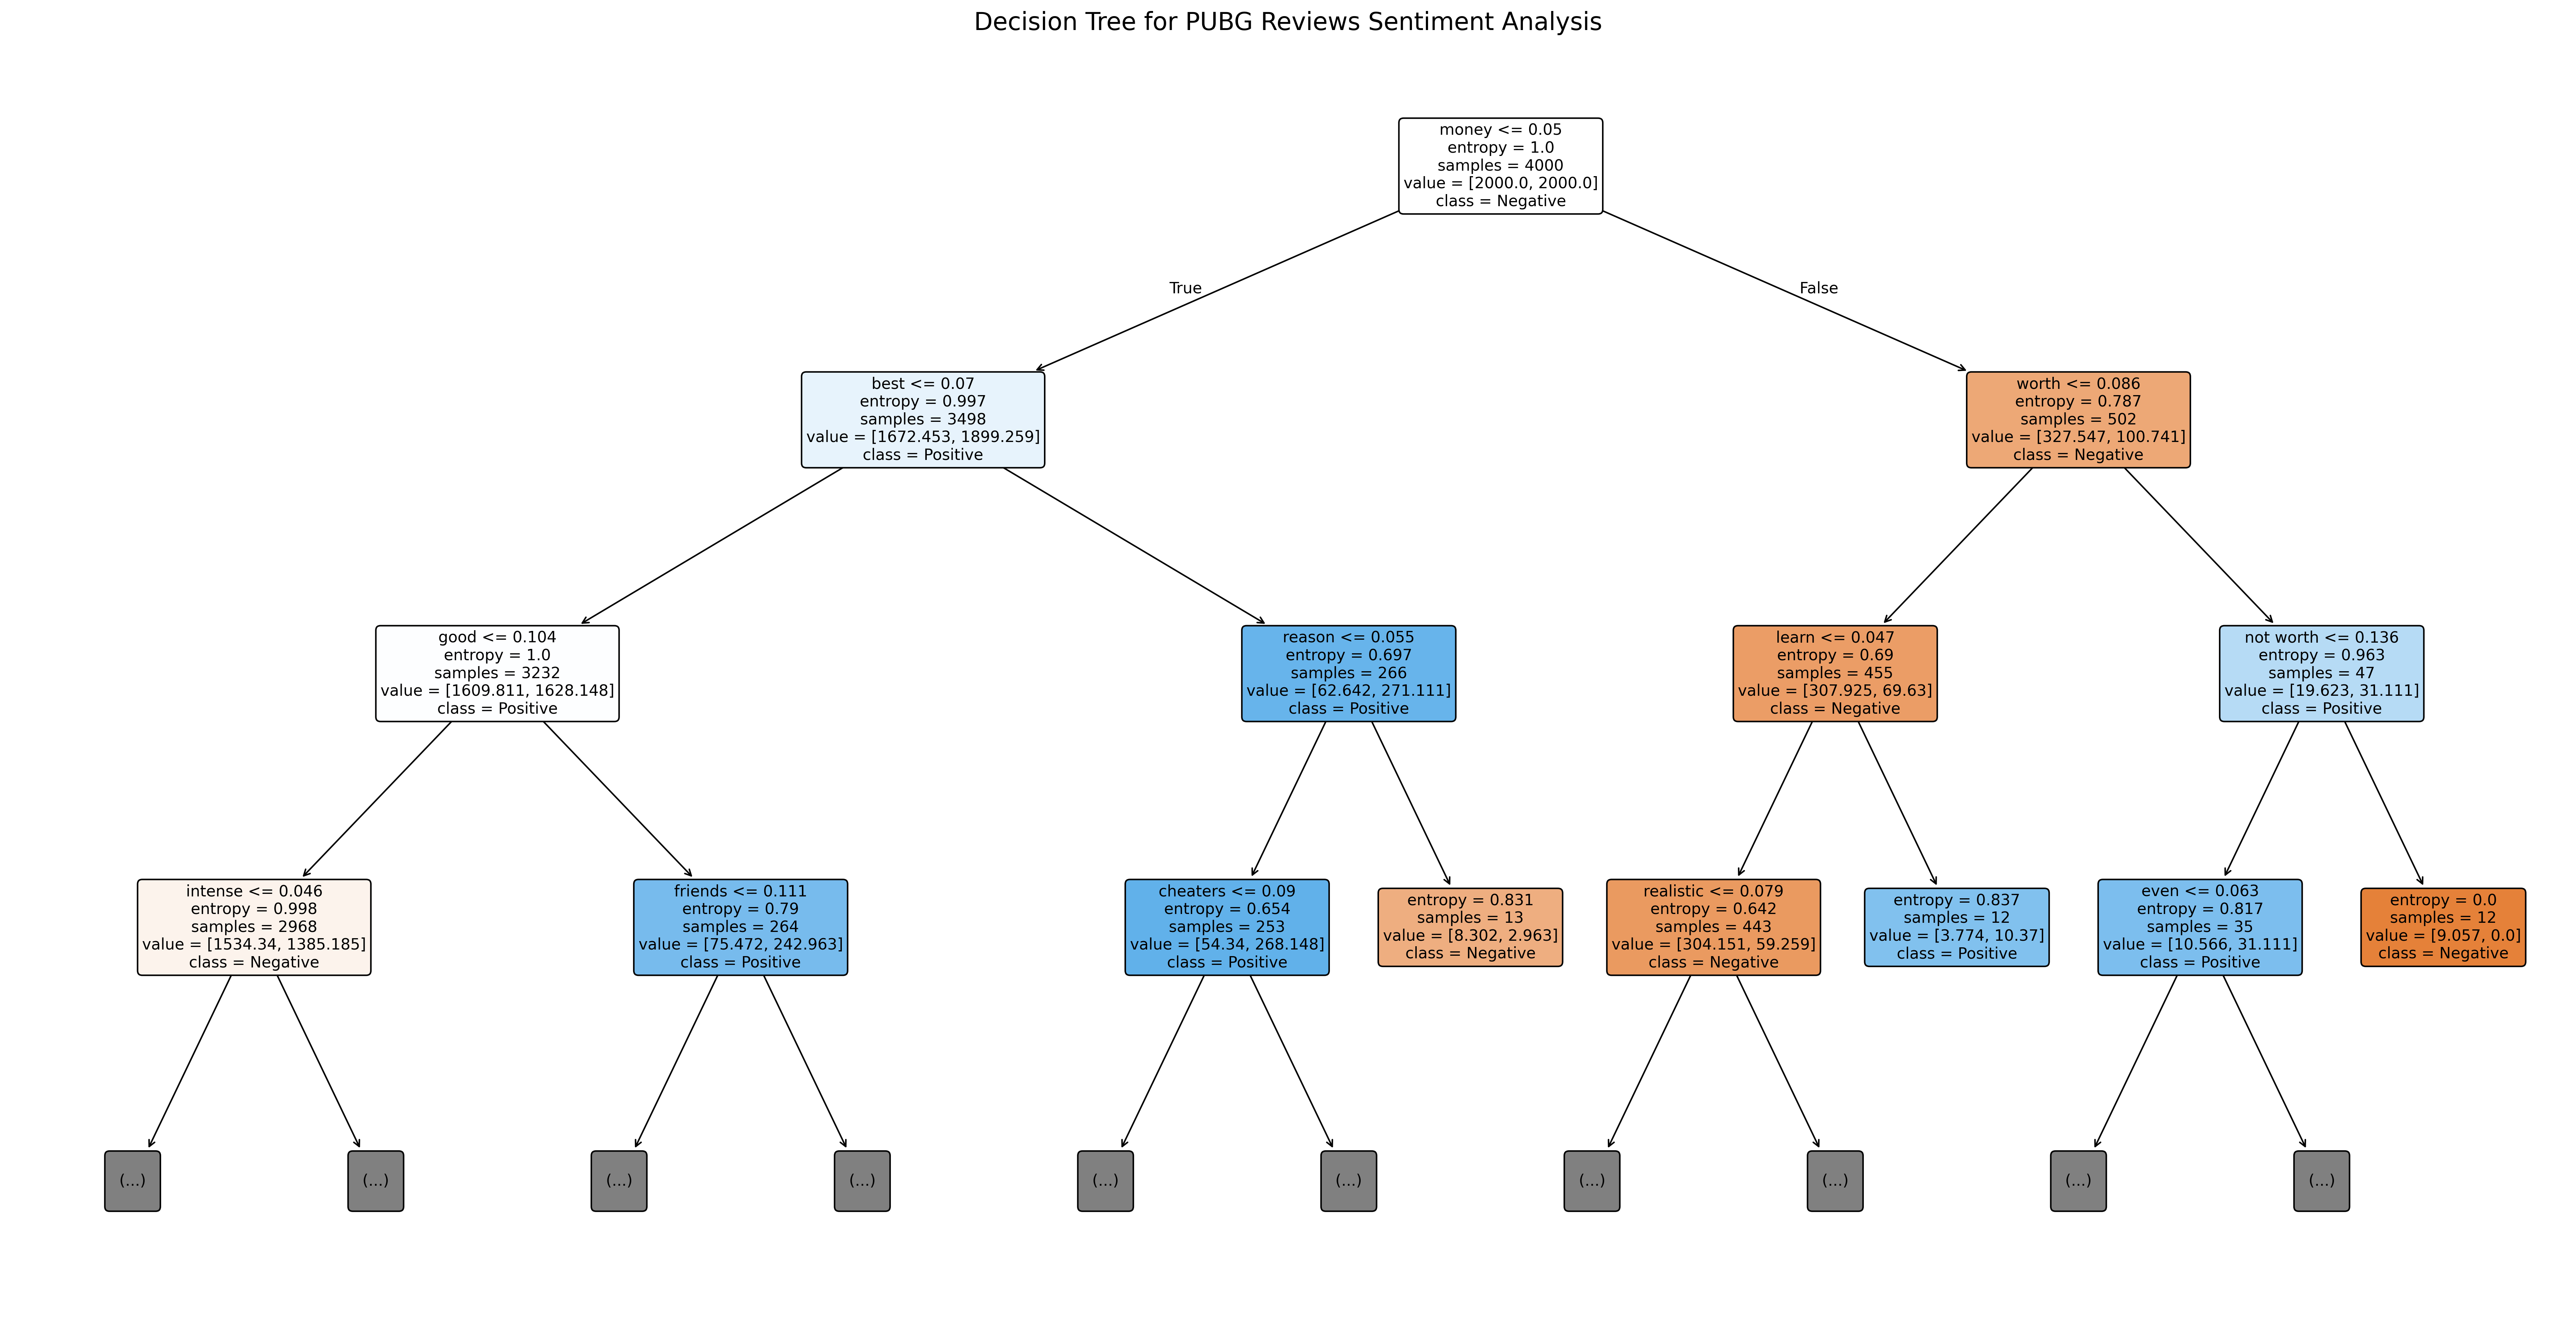

In [43]:
# Visualize the decision tree
plt.figure(figsize=(30,15), dpi=300)  # Increased figure size and DPI
plot_tree(dt_model,
          feature_names=tfidf.get_feature_names_out(),
          class_names=['Negative', 'Positive'],
          filled=True,
          rounded=True,
          max_depth=3)  # Limiting depth for better visualization
plt.title('Decision Tree for PUBG Reviews Sentiment Analysis', fontsize=16)
plt.savefig('decision_tree.png', bbox_inches='tight', dpi=300)  # Save high-resolution image
plt.show()

In [44]:
# Analyze reviews containing the word 'shit'
print("\nAnalyzing reviews containing 'shit'...")
shit_reviews = reviews_df[reviews_df['review'].str.contains(r'\bshit\b', case=False, na=False)]

print(f"\nTotal reviews containing 'shit': {len(shit_reviews)}")
print("\nSentiment distribution for these reviews:")
print(shit_reviews['voted_up'].value_counts(normalize=True).map('{:.2%}'.format))

print("\nSample of reviews containing 'shit':")
for idx, row in shit_reviews.head().iterrows():
    print(f"\nReview: {row['review']}")
    print(f"Actual sentiment: {'Positive' if row['voted_up'] else 'Negative'}")

    # Get the prediction for this review
    processed = preprocess_text(row['review'])
    vectorized = tfidf.transform([processed])
    prediction = dt_model.predict(vectorized)[0]
    probs = dt_model.predict_proba(vectorized)[0]
    print(f"Model prediction: {'Positive' if prediction else 'Negative'}")
    print(f"Prediction probabilities: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")


Analyzing reviews containing 'shit'...

Total reviews containing 'shit': 394

Sentiment distribution for these reviews:
voted_up
False    88.32%
True     11.68%
Name: proportion, dtype: object

Sample of reviews containing 'shit':

Review: I've encountered this game just like 99,9% of it's player-base did, by watching Twitch streams and youtube videos.
Being something relatively new in the multiplayer scene (THAT ACTUALLY HAD A MASSIVE PLAYER-BASE), I managed to talk few of my friends into playing it.

I'm not going to lie, we've spent hundreds of hours on it.

That was until the official release of 1.0
Keep in mind that we're talking about previously most played game in the world at some point, a game which brought it's developers millions (if not 10 digit numbers), and as any sane person, you'd expect that it will be poured into further development and fixes, right?

LOL wrong. We're talking about Bluehole here.

You really have to be next level special in order to stumble upon a go

In [45]:
# Test the improved model with context-sensitive examples
context_test_cases = [
    "This game is shit",  # Should be negative
    "This game is the shit!",  # Should be positive
    "Not a bad game at all",  # Should be positive
    "This isn't good",  # Should be negative
    "The graphics are amazing but the gameplay is terrible",  # Mixed sentiment
    "This would be good if it wasn't so buggy",  # Negative with context
    "This is some good shit right here",  # Positive slang
    "The game is boring and uninteresting",  # Negative without strong language
    "This update is not the best thing ever",  # Subtle negative
    "This is straight up fire",  # Modern positive slang
]

print("Testing context-aware sentiment analysis:")
for text in context_test_cases:
    processed = preprocess_text(text)
    vectorized = tfidf.transform([processed])
    prediction = dt_model.predict(vectorized)[0]
    probs = dt_model.predict_proba(vectorized)[0]

    print(f"\nText: {text}")
    print(f"Processed: {processed}")
    print(f"Prediction: {'Positive' if prediction else 'Negative'}")
    print(f"Confidence: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")


Testing context-aware sentiment analysis:

Text: This game is shit
Processed: game terrible
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: This game is the shit!
Processed: game amazing !
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: Not a bad game at all
Processed: not bad game
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: This isn't good
Processed: notgood
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: The graphics are amazing but the gameplay is terrible
Processed: graphics amazing gameplay terrible
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: This would be good if it wasn't so buggy
Processed: would good wasnt buggy
Prediction: Positive
Confidence: Negative=26.64%, Positive=73.36%

Text: This is some good shit right here
Processed: amazing right
Prediction: Negative
Confidence: Negative=59.02%, Positive=40.98%

Text: The game is boring and uninterest

In [ ]:
# Debug the classification of 'shit' in different contexts
print("Debugging 'shit' classification:")

# Get feature index for relevant terms
feature_indices = {}
for term in ['shit', 'very_good', 'the shit', 'da shit']:
    matches = [i for i, feat in enumerate(tfidf.get_feature_names_out()) if term in feat]
    if matches:
        feature_indices[term] = matches

print("\nRelevant feature indices:")
for term, indices in feature_indices.items():
    print(f"{term}: {indices}")
    for idx in indices:
        print(f"  - {tfidf.get_feature_names_out()[idx]} (importance: {dt_model.feature_importances_[idx]:.6f})")

# Test cases specifically for 'shit'
shit_test_cases = [
    "This game is complete shit",
    "This game is the shit",
    "This is some shit game",
    "The game is shit",
    "This shit is amazing"
]

print("\nDetailed analysis of 'shit' test cases:")
for text in shit_test_cases:
    print(f"\nOriginal text: {text}")
    processed = preprocess_text(text)
    print(f"Processed text: {processed}")

    # Get the feature vector
    vector = tfidf.transform([processed])

    # Show non-zero features
    non_zero = vector.nonzero()[1]
    print("Active features:")
    for idx in non_zero:
        feature = tfidf.get_feature_names_out()[idx]
        value = vector[0, idx]
        print(f"  - {feature}: {value:.4f} (importance: {dt_model.feature_importances_[idx]:.6f})")

    # Get prediction and probabilities
    prediction = dt_model.predict(vector)[0]
    probs = dt_model.predict_proba(vector)[0]
    print(f"Prediction: {'Positive' if prediction else 'Negative'}")
    print(f"Probabilities: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")

# Analyze the decision path
print("\nDecision path analysis for 'This game is shit':")
text = "This game is shit"
processed = preprocess_text(text)
vector = tfidf.transform([processed])

node_indicator = dt_model.decision_path(vector)
leaf_id = dt_model.apply(vector)

# Get decision path
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

for node_id in node_index:
    if dt_model.tree_.feature[node_id] != -2:  # not a leaf
        feature = tfidf.get_feature_names_out()[dt_model.tree_.feature[node_id]]
        threshold = dt_model.tree_.threshold[node_id]
        print(f"\nNode {node_id}:")
        print(f"  Feature: {feature}")
        print(f"  Threshold: {threshold}")
        print(f"  Current value: {vector[0, dt_model.tree_.feature[node_id]]}")

In [21]:
def analyze_sentiment(text: str, model, vectorizer) -> str:
    """Analyze the sentiment of a given text using the trained model."""
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])

    # Predict
    prediction = model.predict(text_vectorized)[0]

    return 'Positive' if prediction else 'Negative'

# Test the analyzer with some example reviews
example_reviews = [
    "Lots of fun, but the matchmaking is terrible.",
    "It's okay, not the best but not the worst either.",
    "I had a lot of fun, but there are some issues that need fixing.",
    "While the game has potential, it suffers from numerous bugs.",
    "Best battle royale game ever, highly recommended!"
]

# Calculate prediction probabilities for the example reviews
print("\nPrediction probabilities:")
for review in example_reviews:
    processed_text = preprocess_text(review)
    text_vectorized = tfidf.transform([processed_text])
    probs = dt_model.predict_proba(text_vectorized)[0]
    prediction = dt_model.predict(text_vectorized)[0]
    sentiment = 'Positive' if prediction else 'Negative'
    print(f"\nReview: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Negative probability: {probs[0]:.2%}")
    print(f"Positive probability: {probs[1]:.2%}")


Prediction probabilities:

Review: Lots of fun, but the matchmaking is terrible.
Predicted Sentiment: Positive
Negative probability: 12.24%
Positive probability: 87.76%

Review: It's okay, not the best but not the worst either.
Predicted Sentiment: Positive
Negative probability: 10.56%
Positive probability: 89.44%

Review: I had a lot of fun, but there are some issues that need fixing.
Predicted Sentiment: Positive
Negative probability: 12.24%
Positive probability: 87.76%

Review: While the game has potential, it suffers from numerous bugs.
Predicted Sentiment: Negative
Negative probability: 80.29%
Positive probability: 19.71%

Review: Best battle royale game ever, highly recommended!
Predicted Sentiment: Positive
Negative probability: 10.56%
Positive probability: 89.44%


## Model Comparison

Key differences between Decision Trees and other models (Naive Bayes, SVM) for sentiment analysis:

1. **Interpretability**: Decision Trees are highly interpretable, making it easy to understand how decisions are made
2. **Feature Importance**: Trees provide clear feature importance rankings
3. **Non-linear Relationships**: Decision Trees can capture non-linear relationships in the data
4. **No Assumptions**: Trees don't make assumptions about data distribution
5. **Visualization**: Tree structure can be visualized for better understanding
6. **Potential Overfitting**: Trees can overfit if not properly tuned with parameters like max_depth

Advantages of Decision Trees:
- Easy to understand and interpret
- Can handle both numerical and categorical data
- Requires little data preparation
- Uses a white box model (if...then rules)
- Possible to validate the model using statistical tests

Disadvantages:
- Can create overly complex trees that don't generalize well
- Can be unstable (small changes in data can result in very different trees)
- May create biased trees if some classes dominate